In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.fftpack import fft,ifft

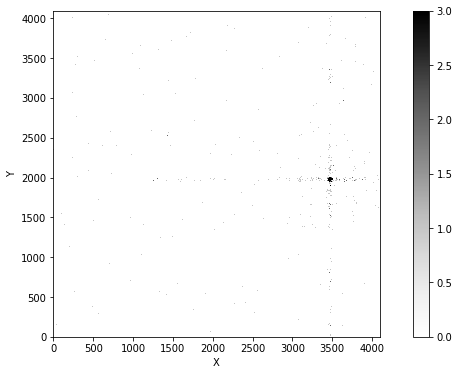

In [2]:
'''
导入数据
画完整图像
'''

sgrb = Table.read(r'sgrb\36.fits').to_pandas()

x = np.array(sgrb['X'])
y = np.array(sgrb['Y'])
PI=np.array(sgrb['PI'])
counts = np.zeros([4096,4096])
for i in range(len(x)):
    counts[x[i]][y[i]] = counts[x[i]][y[i]]+1

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(counts.T,cmap='Greys',origin='low')
cbar = fig.colorbar(im, ax=ax)
#cbar.minorticks_on()
#im.set_clim(0,np.percentile(counts.flatten(),98))
im.set_clim(0,3)
plt.show()

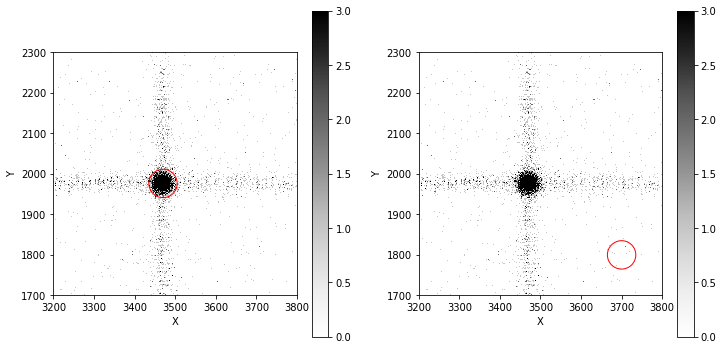

In [16]:
fig = plt.figure(figsize=[12,6])

'''
局域检查
定义源区域
'''
ax1 = fig.add_subplot(121)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(3200, 3800)
ax1.set_ylim(1700, 2300)
im = ax1.imshow(counts.T,cmap='Greys',origin='low')
cbar = fig.colorbar(im, ax=ax1)
#cbar.minorticks_on()
#im.set_clim(0,np.percentile(counts.flatten(),98))
im.set_clim(0,3)

source_point = [3470,1976]   # 源中心点坐标
x0, y0 = source_point[0], source_point[1]
r0 = 35   # 源半径
circle = plt.Circle((x0, y0), r0, color='r', linewidth=1, fill=False)
plt.gcf().gca().add_artist(circle)


'''
定义背景区域
'''
ax2 = fig.add_subplot(122)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_xlim(3200, 3800)
ax2.set_ylim(1700, 2300)
im = ax2.imshow(counts.T,cmap='Greys',origin='low')
cbar = fig.colorbar(im, ax=ax2)
#cbar.minorticks_on()
#im.set_clim(0,np.percentile(counts.flatten(),98))
im.set_clim(0,3)

back_point = [3700,1800]   # 背景区域中心点
xb, yb = back_point[0], back_point[1]
rb = 35   # 背景区域半径
circle = plt.Circle((xb, yb), rb, color='r', linewidth=1, fill=False)
plt.gcf().gca().add_artist(circle)

plt.show()

In [4]:
def circle(r,center_x,center_y):   # 画圆取坐标
    x=[]
    y=[]
    for i in range(4096):
        for j in range(4096):
            if (i-center_x)**2+(j-center_y)**2<=r**2 and (i-center_x)**2+(j-center_y)**2>(r-1)**2:
                x.append(i)
                y.append(j)
            else:
                pass
    return np.array(x),np.array(y)

def event_time(df,r,center_x,center_y):
    x=np.array(df['X'])
    y=np.array(df['Y'])
    value=0.
    for i in range(len(x)):
        if (x[i]-center_x)**2+(y[i]-center_y)**2<=r**2:
            value=value+1.
        else:pass
    return value

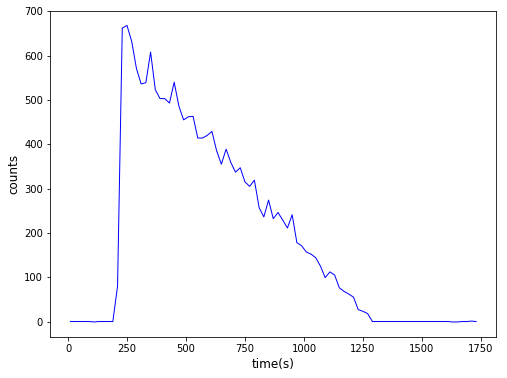

In [18]:
'''
提取时间信息
画出光变曲线
'''

time = np.array(sgrb['TIME'])   # 提取时间信息
dt = 20   # 时间步长

xgrade = np.arange(time.min(),time.max()+dt,dt)
value = []
vback = []
for i in range(1,len(xgrade)):
    df = sgrb[(sgrb['TIME']>=xgrade[i-1]) & (sgrb['TIME']<xgrade[i])]
    value.append(event_time(df,r0,x0,y0))
    vback.append(event_time(df,rb,xb,yb))
value = np.array(value)
vback = np.array(vback)
xgrade = xgrade-time[0]
value_x = (xgrade[:-1]+xgrade[1:])/2.
rate_clean = value - vback


fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.set_xlabel('time(s)',fontsize=12)
ax.set_ylabel('counts',fontsize=12)
#ax.scatter(value_x,value,c='blue',marker='o',s=1.5)
ax.plot(value_x,rate_clean,'b-',linewidth=1,markersize=4)
plt.show()

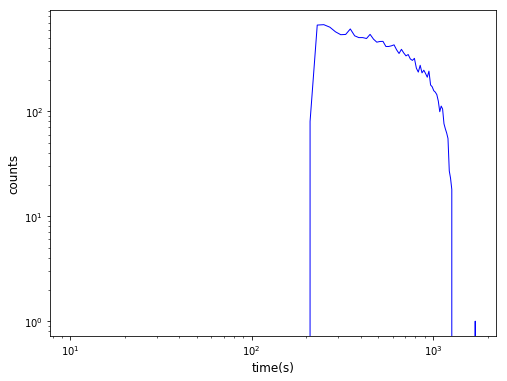

In [19]:
'''
对数坐标下检查
'''

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.loglog()
ax.set_xlabel('time(s)',fontsize=12)
ax.set_ylabel('counts',fontsize=12)
#ax.scatter(value_x,value,c='blue',marker='o',s=1.5)
ax.plot(value_x,rate_clean,'b-',linewidth=1,markersize=4)
plt.show()

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


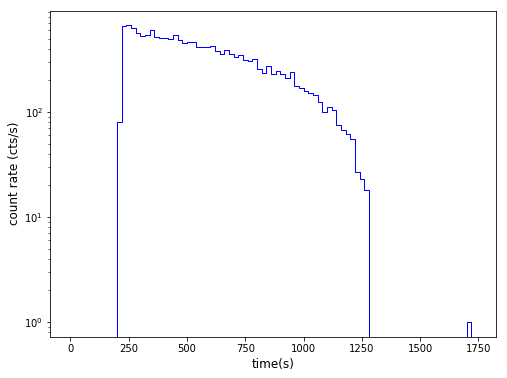

In [20]:
'''
等时间间距划分
为功率谱做准备
'''

dt = 20
time_list = np.arange(0, 1750+dt, dt)
rate_list = []
for i in range(1,len(time_list)):
    ints = (value_x<time_list[i])&(value_x>=time_list[i-1])
    rate_new = np.mean(rate_clean[ints])
    rate_list.append(rate_new)

rate_list = np.array(rate_list)
rate_list[np.isnan(rate_list)] = 0
time_list = np.arange(0, 1750, dt)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel('time(s)',fontsize=12)
ax.set_ylabel('count rate (cts/s)',fontsize=12)
#ax1.scatter(time_list,rate_clean,c='blue',marker='o',s=1.5) 
ax.step(time_list,rate_list,'b-',linewidth=1,where='post')
plt.show()

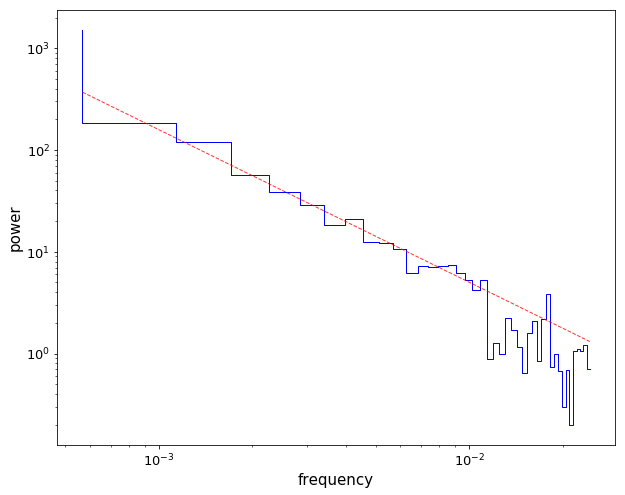

In [33]:
'''
功率谱
'''

N = len(rate_list)

nf = N/2    # Nyquist
df = 1/(dt*N)
F_a = np.arange(nf+1)
F = [i*df for i in F_a]
F1 = F[1:int(nf)]    # 除去f=0及f=f_Nyquist
mean_x = np.mean(rate_list)
dft = fft(rate_list-mean_x)
dft1 = dft[1:int(nf)]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

F1 = np.array(F1)
line = F1**(-1.5)*(10**(-2.3))

plt.figure(figsize=(10,8))
plt.loglog()
plt.step(F1, per_data, color="b", linewidth=1)
plt.plot(F1, line, "r--", alpha=0.8, linewidth=1)
plt.xlabel("frequency",fontsize=15)
plt.ylabel("power",fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

perlist = {'f':F1,'per':per_data}
test = pd.DataFrame(perlist,columns = ['f','per'])
test.to_csv('perlist_sgrb.csv')

Text(0,0.5,'counts')

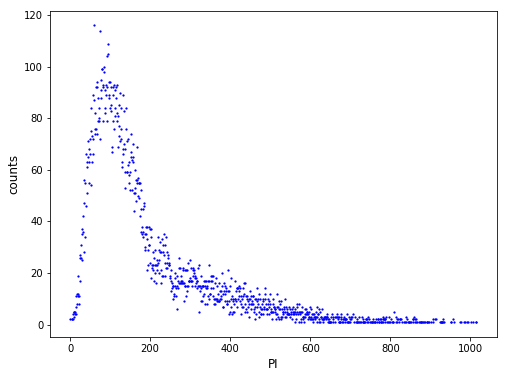

In [8]:
'''
提取能量信息
'''

source_PI=[]
for i in range(len(x)):   # 提取源区域内的 PI 信息
    if (x[i]-x0)**2+(y[i]-y0)**2<=r0**2:
        source_PI.append(PI[i])
    else:
        pass
sta=Counter(source_PI)
energy_x=np.array(list(sta.keys()))
energy_y=np.array(list(sta.values()))

fig = plt.figure(figsize=[8,6])
plt.scatter(energy_x,energy_y,c='blue',marker='o',s=1.5)
plt.xlabel('PI',fontsize=12)
plt.ylabel('counts',fontsize=12)

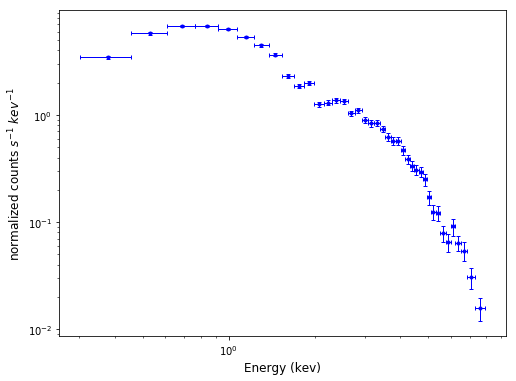

In [15]:
'''
从XSPEC中得到的能谱
'''

energy = pd.read_csv("energy_sgrb.csv")  
x = energy['x']
y = energy['y']
xerr = energy['xerr']
yerr = energy['yerr']

fig=plt.figure(figsize=[8,6])
ax=fig.add_subplot(111)
#ax.scatter(E,Count,c='blue',marker='o',s=3)
ax.errorbar(x,y, yerr=yerr, xerr=xerr, fmt='.', color='b', elinewidth=1, capsize=2)
ax.set_xlabel('Energy (kev)',fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(10**(-2),10**3)
#ax.set_xlim(10**(-1),10**1)
ax.set_ylabel('normalized counts $s^{-1}$ $kev^{-1}$',fontsize=12)
#ax.set_ylim(0,12)
plt.show()